In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy.signal import convolve
from scipy import ndimage
import getBayer
% matplotlib inline
import io
import time
import copy
from numpy.lib.stride_tricks import as_strided

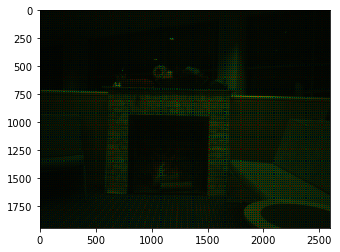

In [47]:
Im = getBayer.getBayer('pic2.jpeg')
bayer = getBayer.bayerGrid 
testIm = copy.deepcopy(Im)

plt.imshow(Im/255)

In [63]:
# trying out a method where you interpolate along a direction based on which seems most constant
(m,n) = testIm[:,:,0].shape
R = testIm[:,:,0].astype(np.int32)
G = testIm[:,:,1].astype(np.int32)
B = testIm[:,:,2].astype(np.int32)
G[0:3,0:3]

array([[14,  0, 15],
       [ 0, 15,  0],
       [13,  0, 15]])

In [64]:
G_n = copy.deepcopy(G)
R_n = copy.deepcopy(R)
B_n = copy.deepcopy(B)

I'm basing the below pixel patterning algorithm on the one detailed in Chuan-kai Lin's website https://sites.google.com/site/chklin/demosaic

In [65]:

for i in range(2,m -3):
    for j in range(2,n-3):
        if G[i,j] == 0:
            if B[i,j] == 0: # if this isn't a blue or green pixel, its a red one
                M = R
            elif R[i,j] == 0:
                M = B
            north = 2*abs(M[i,j] -M[i-2,j]) + abs(G[i-1,j] - G[i+1,j])
            east = 2*abs(M[i,j] -M[i,j+2]) + abs(G[i,j+1] - G[i,j-1])
            south = 2*abs(M[i,j] -M[i+2,j]) + abs(G[i-1,j] - G[i+1,j])
            west = 2*abs(M[i,j] -M[i,j-2]) + abs(G[i,j+1] - G[i,j-1])
#             print(north)
            grads = [north, east, south, west]
            if min(grads) == north:
                G_n[i,j] = (3*G[i-1,j] + G[i+1,j] + M[i,j] -M[i-2,j])/4
            elif min(grads) == east:
                G_n[i,j] = (3*G[i,j+1] + G[i,j-1] + M[i,j] -M[i,j+2])/4
            elif min(grads) == south:
                G_n[i,j] = (3*G[i+1,j] + G[i-1,j] + M[i,j] -M[i+2,j])/4
            elif min(grads) == west:
                G_n[i,j] = (3*G[i,j-1] + G[i,j+1] + M[i,j] -M[i,j-2])/4
                
          

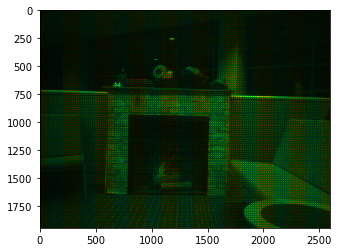

In [66]:
temp = testIm.copy()
temp[:,:,1] = G_n[:,:]

plt.imshow(temp/255)

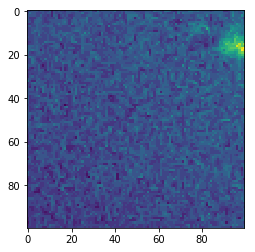

In [67]:
plt.imshow(G_n[100:200,100:200])

In [68]:
#make a hue gradient function
def hueGrad(c1, c2, c3, p1, p3):
    if c1< c2 and c2 < c3 or c3< c2 and c2 < c1: 
        return p1 + (p3-p1)*(c2 - c1)/(c3-c1)
    else:
        return (p1+p3)/2 + (2*c2 + c1 + c3)/4

I'm not following the algorithm I was before here, I'm mostly just doing bilinear interpolation

In [69]:

for i in range(1,m-2):
    for j in range(1,n-2):
        if R[i,j] == 0 and B[i,j] ==0: #Green sencel location
            if R[i+1,j] == 0: # this means that the next pixel in the bayer grid directly below is a blue one
                R_n[i,j] = abs(R[i,j-1] + R[i,j+1])//2
                B_n[i,j] = abs(B[i-1,j] + B[i+1,j])//2
#                 R_n[i,j] = hueGrad(G_n[i,j-1], G_n[i,j], G_n[i,j+1], R[i,j-1], R[i,j+1]) 
#                 B_n[i,j] = hueGrad(G_n[i-1,j], G_n[i,j], G_n[i+1,j], B[i-1,j], B[i+1,j])
            elif B[i+1,j] == 0:
                R_n[i,j] = abs(R[i-1,j] + R[i+1,j])//2    
                B_n[i,j] = abs(B[i,j-1] + B[i,j+1])//2
#                 B_n[i,j] = hueGrad(G_n[i,j-1], G_n[i,j], G_n[i,j+1], B[i,j-1], B[i,j+1]) 
#                 R_n[i,j] = hueGrad(G_n[i-1,j], G_n[i,j], G_n[i+1,j], R[i-1,j], R[i+1,j])
        elif B[i,j] == 0 and G[i,j] ==0: # the sencel location is a Blue one
            NE = abs(B[i-1,j+1] - B[i+1, j-1])
            NW = abs(B[i-1, j-1] - B[i+1,j+1])
            if NW > 2*NE:
                B_n[i,j] = abs(B[i-1,j+1] + B[i+1, j-1])//2
            elif NE > 2*NW: 
                B_n[i,j] = abs(B[i-1, j-1] + B[i+1,j+1])//2
            else: 
                B_n[i,j] = abs(B[i-1, j-1] + B[i+1,j+1] + B[i-1,j+1] + B[i+1, j-1])//4
            
        elif R[i,j] == 0 and G[i,j]==0: #Sencel in this location is Red      
            NE = abs(R[i-1,j+1] - R[i+1, j-1])
            NW = abs(R[i-1, j-1] - R[i+1,j+1])
            if NW > 2*NE:
                R_n[i,j] = abs(R[i-1,j+1] + R[i+1, j-1])//2
            elif NE > 2*NW: 
                R_n[i,j] = abs(R[i-1, j-1] + R[i+1,j+1])//2
            else: 
                R_n[i,j] = abs(R[i-1, j-1] + R[i+1,j+1] + R[i-1,j+1] + R[i+1, j-1])//4

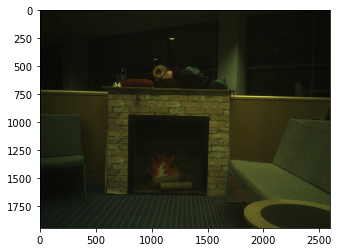

In [77]:
temp[:,:,0] = R_n[:,:]
temp[:,:,2] = B_n[:,:]

plt.imshow(temp/255)

In [72]:
# plt.imshow(testIm[100:120,100:120,0]/255, cmap = 'gray')
B_n[50:60,50:60]

array([[ 9,  8,  8,  9,  8,  8,  8,  9,  9,  9],
       [ 8,  8,  8,  8,  8,  7,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  7,  6,  7,  8,  8,  8],
       [ 8,  8,  8,  9,  8,  7,  8,  8,  8,  9],
       [ 7,  8,  9, 10,  9,  9,  9,  9,  9, 10],
       [ 8,  8,  8,  9,  9,  9,  9,  8,  9,  9],
       [ 9,  9,  8,  8,  8,  9,  8,  8,  8,  9],
       [ 8,  8,  7,  7,  8,  9,  9,  8,  9,  9],
       [ 7,  7,  7,  7,  8, 10,  9,  9,  9,  9],
       [ 7,  7,  7,  7,  8,  9,  8,  8,  8,  8]])

In [73]:
# B[50:60,50:60]
B_n.shape

(1944, 2592)

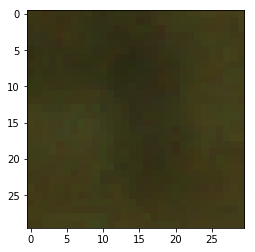

In [83]:
plt.imshow(temp[850:880,870:900]/255)

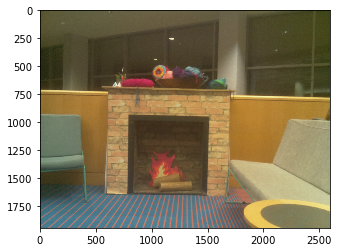

In [87]:
rgbIm = getBayer.get_rgb_array('pic2.jpeg')
plt.imshow(rgbIm/255)